In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f1986cdb-f44f-bd5c-9066-a56bd54f2c9e)


In [ ]:
from numba import cuda, float64
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas as pd
import time
import math

#### Numpy

In [ ]:
numpy_perf = []
for N in [128, 256, 512, 1024, 1536, 2048, 2560, 3072, 3584, 4096]:
  np.random.seed(1)

  A = np.random.uniform(0,1,(N,N))
  B = np.random.uniform(0,1,(N,N))

  start = time.time()
  np.matmul(A,B)
  stop = time.time()
  elapsed = stop - start

  m = A.shape[0]  # row number A
  n = A.shape[1]  # col number A = row number B
  p = B.shape[1]  # col number B

  # Compute flops and performance as GFlops
  flops = m * p * (n + n - 1)
  flops2gflops = 1/10**9
  perf = flops / elapsed * flops2gflops
  
  numpy_perf.append(perf)

#### Naive Python

In [ ]:
# Naive matmul
@cuda.jit
def naive_matmul(A,B,C):
  r = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  c = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y 
  
  temp = 0       # initialise temporary variable for each element of C
  
  for k in range(A.shape[1]):
    temp += A[r, k] * B[k, c]      # compute dot product
  
  C[r, c] = temp     # assign temporary variable to C matrix

#------------------------------------

naive_perf = []

# Tile size
T = 8

for N in [128, 256, 512, 1024, 1536, 2048, 2560, 3072, 3584, 4096]:
  np.random.seed(1)
  A = np.random.uniform(0,1,(N,N))
  B = np.random.uniform(0,1,(N,N))
  C = np.zeros((N,N))

  # Blocks per grid
  bpg = math.ceil(A.shape[0] / T)

  THREADS = (T,T)
  BLOCKS = (bpg,bpg)

  start = time.time()
  naive_matmul[BLOCKS, THREADS](A,B,C)
  stop = time.time()
  elapsed = stop - start

  m = A.shape[0]  # row number A
  n = A.shape[1]  # col number A = row number B
  p = B.shape[1]  # col number B

  # Compute flops and performance as GFlops
  flops = m * p * (n + n - 1)
  flops2gflops = 1/10**9
  perf = flops / elapsed * flops2gflops
  
  # Store performances in list
  naive_perf.append(perf)

#### Shared Meomory - Tile 8x8

In [ ]:
@cuda.jit
def sm_matmul(A,B,C): 
  # Initialise 2D array in shared memory
  # Each array will have a shape of TxT elements
  # Data type: double precision (float64)
  sA = cuda.shared.array(shape=(T,T), dtype=float64)
  sB = cuda.shared.array(shape=(T,T), dtype=float64)

  # Global memory matrices x and y dimensions index
  r = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  c = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  
  # Shared memory indexes
  tr = cuda.threadIdx.x
  tc = cuda.threadIdx.y
  
  temp = 0
  # Loop over all square submatrices of A and B needed to compute an element of C
  # Load shared memory arrays
  for i in range(math.ceil(A.shape[0]/T)):
    sA[tr, tc] = A[r, tc + i * T]
    sB[tr, tc] = B[tr + i * T, c]

    # Ensure each thread has finished loading
    cuda.syncthreads()

    # Copute dot product and store result in temporary variable  
    for k in range(T):
      temp += sA[tr, k] * sB[k, tc]
    
    # Ensure each thread has finished calculations
    cuda.syncthreads()

  # Assign temporary variable to element of C
  C[r,c] = temp

#--------------------------------

perf_2 = []

#Tile size
T = 8

for N in [128, 256, 512, 1024, 1536, 2048, 2560, 3072, 3584, 4096]:  
  np.random.seed(1)
  A = np.random.uniform(0,1,(N,N))
  B = np.random.uniform(0,1,(N,N))
  C = np.zeros((N,N))

  # Blocks per grid
  bpg = math.ceil(A.shape[0] / T)

  THREADS = (T,T)
  BLOCKS = (bpg,bpg)

  start = time.time()
  sm_matmul[BLOCKS, THREADS](A,B,C)
  stop = time.time()
  elapsed = stop - start

  m = A.shape[0]  # row number A
  n = A.shape[1]  # col number A = row number B
  p = B.shape[1]  # col number B

  flops = m * p * (n + n - 1)
  flops2gflops = 1/10**9
  perf = flops / elapsed * flops2gflops

  perf_2.append(perf)

#### Shared Memory - Tile 8x8 - Fused Multiply Add

In [ ]:
@cuda.jit
def sm_fma_matmul(A,B,C): 
  sA = cuda.shared.array(shape=(T,T), dtype=float64)
  sB = cuda.shared.array(shape=(T,T), dtype=float64)

  r = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  c = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  tr = cuda.threadIdx.x
  tc = cuda.threadIdx.y

  temp = 0
  for i in range(math.ceil(A.shape[0]/T)):
    sA[tr, tc] = A[r, tc + i * T]
    sB[tr, tc] = B[tr + i * T, c]
      
    cuda.syncthreads()

    for k in range(T):
      temp = cuda.fma(sA[tr, k], sB[k, tc], temp)  # Use cuda.fma() to apply fused multiply-add

    cuda.syncthreads()
      
  C[r,c] = temp

#------------------------------------

perf_3 = []

# Tile size
T = 8

for N in [128, 256, 512, 1024, 1536, 2048, 2560, 3072, 3584, 4096]:
  np.random.seed(1)
  A = np.random.uniform(0,1,(N,N))
  B = np.random.uniform(0,1,(N,N))
  C = np.zeros((N,N))

  bpg = math.ceil(A.shape[0] / T)

  THREADS = (T,T)
  BLOCKS = (bpg,bpg)

  start = time.time()
  sm_fma_matmul[BLOCKS, THREADS](A,B,C)
  stop = time.time()
  elapsed = stop - start

  m = A.shape[0]  # row number A
  n = A.shape[1]  # col number A = row number B
  p = B.shape[1]  # col number B

  flops = m * p * (n + n - 1)
  flops2gflops = 1/10**9
  perf = flops / elapsed * flops2gflops
  perf_3.append(perf)

#### Shared Memory - Tile 8x8 - Loop Unrolling

In [ ]:
@cuda.jit(fastmath=True)
def unroll_matmul(A,B,C): 
  sA = cuda.shared.array(shape=(T,T), dtype=float64)
  sB = cuda.shared.array(shape=(T,T), dtype=float64)

  r = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  c = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  tr = cuda.threadIdx.x
  tc = cuda.threadIdx.y

  temp = 0
  for i in range(math.ceil(A.shape[0]/T)):
    sA[tr, tc] = A[r, tc + i * T]
    sB[tr, tc] = B[tr + i * T, c]
    
    cuda.syncthreads()
    
    # Unroll loop
    temp += sA[tr, 0] * sB[0, tc]
    temp += sA[tr, 1] * sB[1, tc]
    temp += sA[tr, 2] * sB[2, tc]
    temp += sA[tr, 3] * sB[3, tc]
    temp += sA[tr, 4] * sB[4, tc]
    temp += sA[tr, 5] * sB[5, tc]
    temp += sA[tr, 6] * sB[6, tc]
    temp += sA[tr, 7] * sB[7, tc]

    cuda.syncthreads()

  C[r,c] = temp

#-----------------------------------------------

perf_4 = []

# Tile size
T = 8

for N in [128, 256, 512, 1024, 1536, 2048, 2560, 3072, 3584, 4096]:
  np.random.seed(1)
  A = np.random.uniform(0,1,(N,N))
  B = np.random.uniform(0,1,(N,N))
  C = np.zeros((N,N))

  # Blocks per grid
  bpg = math.ceil(A.shape[0] / T)

  THREADS = (T,T)
  BLOCKS = (bpg,bpg)

  start = time.time()
  unroll_matmul[BLOCKS, THREADS](A,B,C)
  stop = time.time()
  elapsed = stop - start

  m = A.shape[0]  # row number A
  n = A.shape[1]  # col number A = row number B
  p = B.shape[1]  # col number B

  flops = m * p * (n + n - 1)
  flops2gflops = 1/10**9
  perf = flops / elapsed * flops2gflops
  perf_4.append(perf)

#### Shared Memory - Tile 8x8 - Swap Shared Memory 2D-Array Indexes

In [ ]:
@cuda.jit(fastmath=True)
def swap_matmul(A,B,C): 
  sA = cuda.shared.array(shape=(T,T), dtype=float64)
  sB = cuda.shared.array(shape=(T,T), dtype=float64)

  r = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  c = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  tr = cuda.threadIdx.x
  tc = cuda.threadIdx.y

  temp = 0
  for i in range(math.ceil(A.shape[0]/T)):
    # Swap row and column indexes of sA and sB
    sA[tc, tr] = A[r, tc + i * T]
    sB[tc, tr] = B[tr + i * T, c]
      
    cuda.syncthreads()

    for k in range (T):
     # Swap positions of k and tr/tc
     temp += sA[k, tr] * sB[tc, k]

    cuda.syncthreads()
  
  C[r,c] = temp

#---------------------------------------------------#

perf_5 = []

T = 8

for N in [128, 256, 512, 1024, 1536, 2048, 2560, 3072, 3584, 4096]:
  np.random.seed(1)
  A = np.random.uniform(0,1,(N,N))
  B = np.random.uniform(0,1,(N,N))
  C = np.zeros((N,N))

  # Blocks per grid
  bpg = math.ceil(A.shape[0] / T)

  THREADS = (T,T)
  BLOCKS = (bpg,bpg)

  start = time.time()
  swap_matmul[BLOCKS, THREADS](A,B,C)
  stop = time.time()
  elapsed = stop - start

  m = A.shape[0]  # row number A
  n = A.shape[1]  # col number A = row number B
  p = B.shape[1]  # col number B

  flops = m * p * (n + n - 1)
  flops2gflops = 1/10**9
  perf = flops / elapsed * flops2gflops
  perf_5.append(perf)

#### Shared Memory - Tile 32x32 - Swap Shared Memory 2D-Array Indexes + Loop Unrolling

In [ ]:
@cuda.jit
def swap_unroll_matmul(A,B,C): 
  sA = cuda.shared.array(shape=(T,T), dtype=float64)
  sB = cuda.shared.array(shape=(T,T), dtype=float64)

  r = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  c = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  tr = cuda.threadIdx.x
  tc = cuda.threadIdx.y

  temp = 0
  for i in range(math.ceil(A.shape[0]/T)):
    sA[tc, tr] = A[r, tc + i * T]
    sB[tc, tr] = B[tr + i * T, c]

    cuda.syncthreads()

    for k in range(0, T, 8):
      temp += sA[k,tr] * sB[tc,k]
      temp += sA[k+1,tr] * sB[tc,k+1]
      temp += sA[k+2,tr] * sB[tc,k+2]
      temp += sA[k+3,tr] * sB[tc,k+3]
      temp += sA[k+4,tr] * sB[tc,k+4]
      temp += sA[k+5,tr] * sB[tc,k+5]
      temp += sA[k+6,tr] * sB[tc,k+6]
      temp += sA[k+7,tr] * sB[tc,k+7]

    cuda.syncthreads()
      
  C[r,c] = temp

#---------------------------------------------------#

perf_6 = []
T = 32
for N in [128, 256, 512, 1024, 1536, 2048, 2560, 3072, 3584, 4096]:
  np.random.seed(1)
  A = np.random.uniform(0,1,(N,N))
  B = np.random.uniform(0,1,(N,N))
  C = np.zeros((N,N))

  # Blocks per grid
  bpg = math.ceil(A.shape[0] / T)

  THREADS = (T,T)
  BLOCKS = (bpg,bpg)

  start = time.time()
  swap_unroll_matmul[BLOCKS, THREADS](A,B,C)
  stop = time.time()
  elapsed = stop - start

  m = A.shape[0]  # row number A
  n = A.shape[1]  # col number A = row number B
  p = B.shape[1]  # col number B

  flops = m * p * (n + n - 1)
  flops2gflops = 1/10**9
  perf = flops / elapsed * flops2gflops
  perf_6.append(perf)

In [ ]:
m_size = []
for N in [128, 256, 512, 1024, 1536, 2048, 2560, 3072, 3584, 4096]:
  m_size.append(N)

In [ ]:
data = {'Numpy': numpy_perf, 'Naive': naive_perf, 'Tile 8':perf_2, 'FMA':perf_3,
        'Unrolling': perf_4, 'Invert Indexing': perf_5, 'Invert + unroll': perf_6,
        'Matrix Size': m_size }
df = pd.DataFrame(data)
df

,Numpy,Naive,Tile 8,FMA,Unrolling,Invert Indexing,Invert + unroll,Matrix Size
0,0.875954,0.014387,0.020321,0.022158,0.012056,0.019718,0.012433,128
1,23.488731,10.800662,6.988190,3.322514,13.249940,7.335245,3.257180,256
2,31.164812,23.937526,38.869320,34.195738,20.208778,43.286527,33.357070,512
3,41.800780,33.200087,76.042310,76.299452,77.791421,94.271157,93.108989,1024
4,43.217287,42.739791,79.461050,81.152018,80.637796,117.135056,112.118983,1536
5,42.412472,67.391410,81.690510,79.765798,80.904734,106.972044,117.505634,2048
6,42.480953,68.306820,82.543303,81.394730,79.586564,103.908054,124.649200,2560
7,40.850994,68.375855,84.436900,83.343404,82.540884,105.739798,130.055662,3072
8,43.930808,68.147799,82.610529,82.379962,81.382796,110.235649,132.350995,3584
9,43.839349,68.561030,84.296081,82.775214,82.294282,105.956277,131.610251,4096


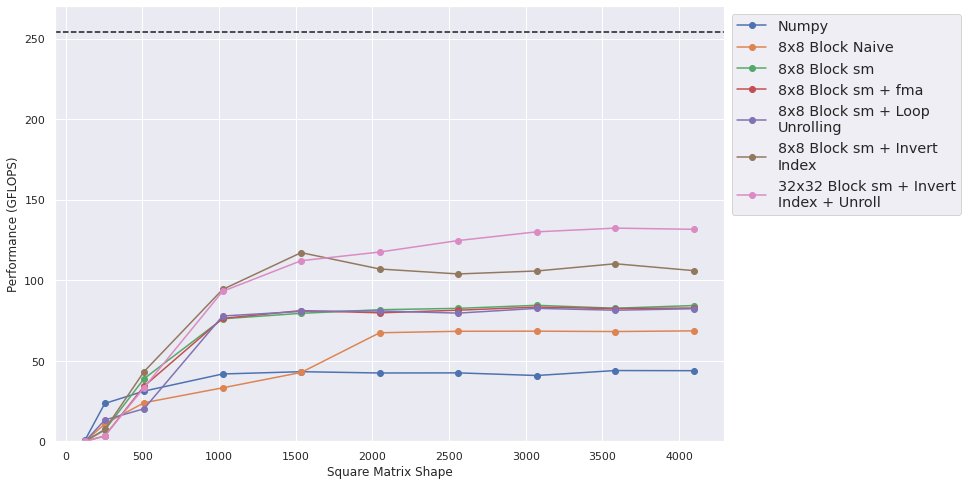

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df['Matrix Size'], df['Numpy'], label='Numpy', marker='o')
ax.plot(df['Matrix Size'], df['Naive'], label='8x8 Block Naive', marker='o')
ax.plot(df['Matrix Size'], df['Tile 8'], label='8x8 Block sm', marker='o')
ax.plot(df['Matrix Size'], df['FMA'], label='8x8 Block sm + fma', marker='o')
ax.plot(df['Matrix Size'], df['Unrolling'], label='8x8 Block sm + Loop\nUnrolling', marker='o')
ax.plot(df['Matrix Size'], df['Invert Indexing'], label='8x8 Block sm + Invert\nIndex', marker='o')
ax.plot(df['Matrix Size'], df['Invert + unroll'], label='32x32 Block sm + Invert\nIndex + Unroll', marker='o')
ax.set_xlabel('Square Matrix Shape')
ax.set_ylabel('Performance (GFLOPS)')
plt.legend(bbox_to_anchor=(1,1), bbox_transform=ax.transAxes, fontsize='large')
ax.set_ylim(0,270)
ax.axhline(y=254.4, ls='--', color='k')
plt.show();

## Test kernels output against Numpy matmul

In [ ]:
N = 512
T = 8

np.random.seed(1)
A = np.random.randint(0,5,size=(N,N))
B = np.random.randint(0,5,size=(N,N))
C = np.zeros((N,N))

bpg = math.ceil(A.shape[0] / T)

THREADS = (T,T)
BLOCKS = (bpg,bpg)

# Define Z = A * B with Numpy matmul
Z = np.matmul(A, B)

# Test output of Naive GPU kernel
naive_matmul[BLOCKS, THREADS](A,B,C)
print((C - Z == 0).all())

# Test output of Shared Memory kernel
sm_matmul[BLOCKS, THREADS](A,B,C)
print((C - Z == 0).all())

# Test output of Shared Memory + Fused Multiply-Add kernel
sm_fma_matmul[BLOCKS, THREADS](A,B,C)
print((C - Z == 0).all())

# Test output of Shared Memory + Loop Unrolling kernel
unroll_matmul[BLOCKS, THREADS](A,B,C)
print((C - Z == 0).all())

# Test output of Shared Memory + Swap Index kernel
swap_matmul[BLOCKS, THREADS](A,B,C)
print((C - Z == 0).all())

# Test output of Shared Memory + Swap Index + Loop Unrolling kernel
swap_unroll_matmul[BLOCKS, THREADS](A,B,C)
print((C - Z == 0).all())

True
True
True
True
True
True
